# Генерация коротких текстов с помощью RNN


Генерировать тексты можно с помощью RNN, предсказывающей следующий символ последовательности по предыдущим.

В этом задании предлагается написать и проучить на небольшом датасете имен [генеративную модель на основе символов -- Char-RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

![charseq](./charseq.jpeg)
Картинка взята из [статьи Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

В файле `names` находится ~8k имен на латинице.

Модель будет получать на вход имя `Amandy` и выдавать его же, только со сдвигом: `mandy `.

Чтобы сеть училась генерировать заглавные буквы, добавим в начало специальный токен, пробел:
```
_Amandy --> Amandy_
```

Для практического использования, на каждом шаге будем подавать на вход букву, предсказанную на предыдущем.
Так что нам потребуется правило для останова генерации (это может быть просто ограничение на количество шагов).
С другой стороны, можно добавить в конец каждого примера обучающей выборки специальный `<EOS>` токен. В данном случае обозначим его `#`:

```
_Amandy --> Amandy#
```

Будем прекращать генерацию при досрочном выпадании `<EOS>`.

In [2]:
import os
start_token = " "
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7578 names: 
 Phyllida#
 Concordia#
 Karoly#
 Avrom#
 Hamlet#
 Kalila#
 Mahalia#
 Ransell#


In [3]:
from collections import Counter, OrderedDict

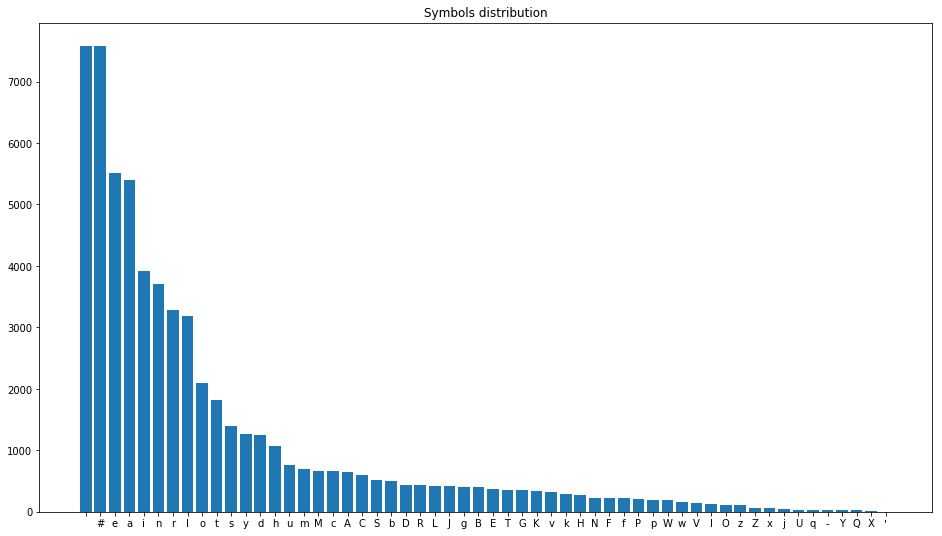

In [4]:
# TODO: постройте частоты употреблений букв
letters = sum([list(name) for name in names], [])
letters_count = OrderedDict(sorted(Counter(letters).items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(16,9))
plt.title('Symbols distribution')
plt.bar(range(len(letters_count)), list(letters_count.values()), align='center')
plt.xticks(range(len(letters_count)), list(letters_count.keys()))
plt.show()
# HINT: для графика возьмите plt.bar

max length = 17


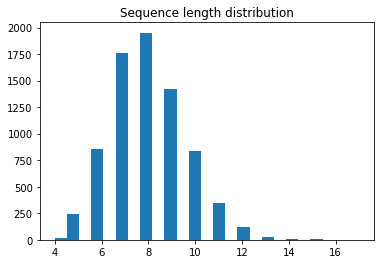

In [5]:
# датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [6]:
names[:10]

[' Phyllida#',
 ' Adelaide#',
 ' Walker#',
 ' Barbi#',
 ' Yuri#',
 ' Lanette#',
 ' Jeremie#',
 ' Stace#',
 ' Florencia#',
 ' Lyle#']

In [7]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы пробел имел номер 0
    
tokens = sorted(list(set(letters)))
    
tok2id = {tok: i for i, tok in enumerate(tokens)}
id2tok = {i: tok for tok, i in tok2id.items()}

n_tokens = len(tokens)
print ('There are {} tokens',n_tokens)

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are {} tokens 56
Vocabular:  #'-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [8]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        #print(name_ix)
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [9]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

 Phyllida#
 Adelaide#
 Walker#
 Barbi#
 Yuri#
 Lanette#
 Jeremie#
 Stace#
 Florencia#
 Lyle#
[[ 0 19 37 54 41 41 38 33 30  1  0]
 [ 0  4 33 34 41 30 38 33 34  1  0]
 [ 0 26 30 41 40 34 47  1  0  0  0]
 [ 0  5 30 47 31 38  1  0  0  0  0]
 [ 0 28 50 47 38  1  0  0  0  0  0]
 [ 0 15 30 43 34 49 49 34  1  0  0]
 [ 0 13 34 47 34 42 38 34  1  0  0]
 [ 0 22 49 30 32 34  1  0  0  0  0]
 [ 0  9 41 44 47 34 43 32 38 30  1]
 [ 0 15 54 41 34  1  0  0  0  0  0]]


In [10]:
# TODO: разбейте все имена на тренировочную и тестовую часть
np.random.seed(13)

def split_data(data, train_size=0.75):
    train_index = np.random.choice(range(len(data)), size=int(train_size * len(data)), replace=False)
    test_index = np.delete(np.arange(len(data)), train_index)
    data = np.array(data)
    return data[train_index], data[test_index]

train_data, val_data = split_data(names)

len(train_data), len(val_data)

(5683, 1895)

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
from IPython.display import clear_output

# Char-RNN для имен (0.2 балла)

Вам нужно написать сеть, кодирующую номера входных символов с помощью таблицы Embeddings. 
Получившиеся тензоры пропустить через RNN ячейку, затем преобразовать в логиты для предсказания номера нового символа.

In [12]:
# NB: обратите внимание на порядок осей при вызове forward
# http://pytorch.org/docs/master/nn.html#recurrent-layers

# Сделайте возможность выбора типа ячейки, RNN, GRU или LSTM
# TODO: заполните пропуски. Функция forward будет вызываться на каждый шаг нами

class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell="rnn", n_layers=1):
        super(NameRNN, self).__init__()
        # добавьте возможность выбрать тип ячейки RNN/LSTM
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.cell = cell
        
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        # cell == LSTM
        if self.cell == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        elif self.cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.cell == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        bs = input.size(0)
        embedded = self.embeddings(input)
        reordered = embedded.view(1, bs, -1)
        output, hidden = self.rnn(reordered, hidden)
        out = self.decoder(output)
        return out.view(bs, -1), hidden

    def init_hidden(self, batch_size):
        if self.cell == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

# Код для тренировки RNN (0.2 балла)

In [13]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        # можно вынести подсчет ошибки в модельку
        
        nums = to_matrix(batch)
        t = Variable(torch.from_numpy(nums))
        hidden = model.init_hidden(t.shape[0])
        loss = 0.0
        for i in range(0, t.shape[1] - 1):
            out, hidden = model.forward(t[:, i], hidden)
            loss += F.cross_entropy(out, t[:, i + 1])
        loss.backward()
        optimizer.step()
            
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:
        nums = to_matrix(batch)
        t = Variable(torch.from_numpy(nums))
        hidden = model.init_hidden(t.shape[0])
        loss = 0.0
        for i in range(0, t.shape[1] - 1):
            out, hidden = model(t[:, i], hidden)
            loss += F.cross_entropy(out, t[:, i + 1])
        loss = loss.data[0]
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

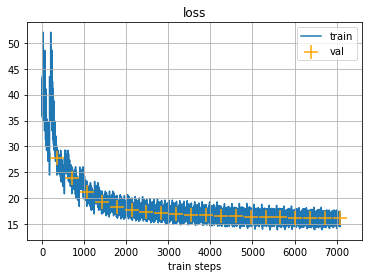

In [14]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='rnn')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

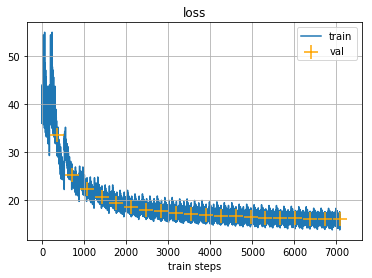

In [15]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='lstm')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

# Генерация по argmax (0.2 балла)

In [16]:
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
    return logits.max(1)[1].data.numpy()[0]

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix=" "):
    hidden = model.init_hidden(1)
    nums = to_matrix(prefix)
    nums = Variable(torch.from_numpy(nums))
    
    # TODO: сначала сверните строку с помощью RNN:
    # нас интересует последний output и hidden
    for inp in nums:
        out, hidden = model.forward(inp, hidden)
    
    # TODO: затем сгенерируйте несколько последующих символов
    # outs -- это массив с номерами токенов
    outs = [pick_by_argmax(out)]
    inp = out.max(1)[1]
    for i in range(10):
        out, hidden = model.forward(inp, hidden)
        outs.append(pick_by_argmax(out))
        inp = out.max(1)[1]
    
    print(prefix + '|'+ ids2string(outs))

gen_continuation(rnn, " Ku")

 Ku|llia#      


# Генерация с семплированием (0.4 балла)

Обычный софтмакс 
$$p_i = \frac{\exp (x_i)}{\sum \exp (x_j)}$$
можно модернизировать с помощью температуры:
$$p_i = \frac{\exp (x_i / T)}{\sum \exp (x_j / T)}$$

Это позволит плавно переходить от выбора наиболее вероятного элемента ($T << 1$) до практически равновероятного ($T >> 1$)


In [17]:
# Напишите функцию генерации батчами с семплированием из распределения и температурой
def batch2string(ids, prefix):
    # модифицируйте ids2string для работы с батчами
    return '\n'.join([prefix + ''.join(id2tok[_] for _ in x) for x in ids])

def pick_by_distribution(logits, temperature):
    # превратите логиты в распределение
    # затем семлируйте из него batch примеров
    distr = torch.exp(logits / temperature) / torch.sum(torch.exp(logits / temperature))
    return np.random.choice(range(len(distr)), size=1, p=distr.data.numpy())[0]

def gen_continuation_temp(model, prefix=" ", temperature=1.0, n=10):
    hidden = model.init_hidden(n)
    nums = to_matrix([prefix] * n)
    nums = Variable(torch.from_numpy(nums))

    # аналогично, сначала получите батч output, hidden
    for i in range(nums.shape[1]):
        out, hidden = rnn.forward(nums[:, i], hidden)
    
    # затем, сгенерируйте n последующих символов
    # в outs положите матрицу номеров токенов и отобразите ее
    outs = []
    for i in range(n):
        outs.append([pick_by_distribution(out[i], temperature)])
    inp = Variable(torch.from_numpy(np.array(outs)).long())
    for i in range(10):
        out, hidden = model.forward(inp, hidden)
        for j in range(n):
            outs[j].append(pick_by_distribution(out[j], temperature))
        inp = Variable(torch.from_numpy(np.array(outs)[:, i + 1]).long())
    
    print(batch2string(outs, prefix + '|'))

In [18]:
gen_continuation_temp(rnn, prefix=" An", temperature=0.5, n=10)

 An|ne#        
 An|relle#     
 An|na#        
 An|amia#      
 An|den#       
 An|da#        
 An|rina#      
 An|da#        
 An|eryn#      
 An|da#        
